# LightGBM regression for spectral data (interval-aggregated evaluation)

This notebook trains a LightGBM regression model to predict `TotalREE` from spectral data.

Purpose
- Demonstrate group-aware cross validation (GroupKFold by depth intervals).
- Produce interval-level (bag) out-of-fold predictions and metrics.
- Provide feature interpretation with SHAP.

Inputs
- `hullq_interval.csv`: spectral data; wavelength columns must be numeric strings (e.g., `400`, `401.5`).
- `folds_groupkfold.json`: optional precomputed folds (GroupKFold indices).

Outputs
- OOF predictions and interval-aggregated metrics printed in the notebook
- Saved plots: `lgbm_oof_profile.png`, `lgbm_oof_scatter.png`

How to run (quick)
1. Create a conda/venv environment and install requirements: numpy, pandas, scikit-learn, lightgbm, shap, matplotlib
2. Open this notebook in VS Code or Jupyter and run the cells in order.

Notes on reproducibility
- The notebook uses deterministic sorting before fold creation to help reproducibility. Keep `RANDOM_STATE` consistent when regenerating folds.

In [1]:
# --- Libraries ---
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, root_mean_squared_error
# Modeling
import lightgbm as lgb
# Interpretation
import shap
# Visualization
import matplotlib.pyplot as plt

c:\Users\thais\miniconda3\envs\hyperspectral-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ===============================================================
# SET RANDOM SEEDS FOR REPRODUCIBILITY
# ===============================================================
import random

RANDOM_STATE = 42

# Seed Python's built-in random
random.seed(RANDOM_STATE)

# Seed NumPy
np.random.seed(RANDOM_STATE)

# Seed scikit-learn and LightGBM (they respect numpy's random state)
# LightGBM will also use random_state parameter in model initialization

print(f"Random seeds set to {RANDOM_STATE} for reproducibility.")

Random seeds set to 42 for reproducibility.


In [3]:
# ===============================================================
# 0. GENERAL CONFIGURATION
# ===============================================================
DATA_CSV = '../data/processed/hullq_interval.csv'  # <-- adjust the name of your CSV if needed
FOLDS_JSON = '../processing/folds_groupkfold.json'  # <-- if not present, folds will be generated here
TARGET_COL = 'TotalREE'
GROUP_COL = 'interval'
DEPTH_COL = 'Depth'
N_SPLITS = 5

# LightGBM parameters (robust base configuration; fine-tune later)
LGBM_PARAMS = dict(
  objective='regression',
  boosting_type='gbdt',
  n_estimators=2000,
  learning_rate=0.03,
  num_leaves=64,
  max_depth=-1,
  subsample=0.8,
  colsample_bytree=0.8,
  reg_lambda=1.0,
  reg_alpha=0.0,
  min_child_samples=20,
  random_state=RANDOM_STATE,
  n_jobs=-1,
)

## 1. Read and prepare dataset

Load the CSV file, perform deterministic sorting for reproducibility, and detect spectral columns (columns with numeric names). Prepare the feature matrix `X`, target vector `y`, and grouping labels used for GroupKFold. Ensure the dataset contains the expected columns (`interval`, `Depth`, and numeric wavelength columns).

In [4]:
def is_numeric_colname(name: str) -> bool:
    """Return True if column name can be parsed as a number (wavelength)."""
    try:
        float(str(name))
        return True
    except Exception:
        return False

# Load CSV
df = pd.read_csv(DATA_CSV)

# Deterministic sorting (important for reproducible fold generation)
sort_cols = [c for c in [GROUP_COL, DEPTH_COL] if c in df.columns]
if sort_cols:
    df = df.sort_values(sort_cols).reset_index(drop=True)

# Select spectral columns: those with numeric names
non_spectral = {GROUP_COL, DEPTH_COL, TARGET_COL}
# spectral_cols are columns representing wavelengths
spectral_cols = [c for c in df.columns if (c not in non_spectral) and is_numeric_colname(c)]
if len(spectral_cols) == 0:
    raise ValueError('No numeric spectral columns found (e.g., 400, 401.5, ...).')

# Prepare arrays for modeling
X = df[spectral_cols].astype(np.float32).values  # spectral features
y = df[TARGET_COL].astype(np.float32).values    # target vector
groups = df[GROUP_COL].values                    # group labels for GroupKFold

## 2. Folds: load or generate

Load precomputed GroupKFold indices from `folds_groupkfold.json` if present. If not, generate deterministic GroupKFold splits using the group labels and save them for reproducibility. This keeps all samples from the same interval together in either train or test.

In [5]:
folds = []

if Path(FOLDS_JSON).exists():
    # Load precomputed folds (list of dicts with 'train' and 'test')
    with open(FOLDS_JSON, 'r', encoding='utf-8') as f:
        folds = json.load(f)
    print(f"[OK] Folds loaded from {FOLDS_JSON} (count={len(folds)})")

# Basic validation
if len(folds) == 0:
    raise RuntimeError('No folds available. Please check FOLDS_JSON or group labels.')

# Print summary of first fold sizes for quick sanity check
first = folds[0]
print(f"Example fold sizes: train={len(first['train'])}, test={len(first['test'])}")

[OK] Folds loaded from ../processing/folds_groupkfold.json (count=5)
Example fold sizes: train=8893, test=2254


## 3. Train and evaluate per fold

Train a LightGBM model on each train fold and evaluate on the corresponding test fold. Store out-of-fold predictions and per-fold metrics (R², RMSE). Models are kept in a list for later interpretation (e.g., SHAP). Use early stopping on validation to avoid overfitting.

In [6]:
oof_pred = np.zeros(len(df), dtype=float)
models: List[lgb.LGBMRegressor] = []
fold_metrics = []

for k, fdict in enumerate(folds, start=1):
    print(f"Fold: {k}")
    tr_idx = np.array(fdict['train'], dtype=int)
    te_idx = np.array(fdict['test'], dtype=int)

    X_tr, y_tr = X[tr_idx], y[tr_idx]
    X_te, y_te = X[te_idx], y[te_idx]

    print(f"Number of samples in X_train: {len(X_tr)}")
    print(f"Number of samples in X_test: {len(X_te)}")

    # Instantiate and fit model
    model = lgb.LGBMRegressor(**LGBM_PARAMS)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_te, y_te)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=200, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )

    # Predict on hold-out fold
    pred_te = model.predict(X_te)
    oof_pred[te_idx] = pred_te
    models.append(model)

    # Compute metrics for this fold
    r2 = r2_score(y_te, pred_te)
    rmse = root_mean_squared_error(y_te, pred_te)
    fold_metrics.append((r2, rmse))
    print(f"Fold {k}: R2={r2:.3f} | RMSE={rmse:.3f} | best_iter={getattr(model, 'best_iteration_', None)}")

Fold: 1
Number of samples in X_train: 8893
Number of samples in X_test: 2254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134892
[LightGBM] [Info] Number of data points in the train set: 8893, number of used features: 529
[LightGBM] [Info] Start training from score 2.758267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134892
[LightGBM] [Info] Number of data points in the train set: 8893, number of used features: 529
[LightGBM] [Info] Start training from score 2.758267
[100]	valid_0's rmse: 1.50711	valid_0's l2: 2.2714
[100]	valid_0's rmse: 1.50711	valid_0's l2: 2.2714
[200]	valid_0's rmse: 1.53149	valid_0's l2: 2.34547
[200]	valid_0's rmse: 1.53149	valid_0's l2: 2.34547


c:\Users\thais\miniconda3\envs\hyperspectral-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1: R2=0.636 | RMSE=1.484 | best_iter=62
Fold: 2
Number of samples in X_train: 8918
Number of samples in X_test: 2229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134894
[LightGBM] [Info] Number of data points in the train set: 8918, number of used features: 529
[LightGBM] [Info] Start training from score 2.963651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134894
[LightGBM] [Info] Number of data points in the train set: 8918, number of used features: 529
[LightGBM] [Info] Start training from score 2.963651
[100]	valid_0's rmse: 1.10238	valid_0's l2: 1.21525
[100]	valid_0's rmse: 1.10238	valid_0's l2: 1.21525
[200]	valid_0's rmse: 1.09416	valid_0's l2: 1.19719
[200]	valid_0's rmse: 1.09416	vali

c:\Users\thais\miniconda3\envs\hyperspectral-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2: R2=0.839 | RMSE=1.090 | best_iter=159
Fold: 3
Number of samples in X_train: 8916
Number of samples in X_test: 2231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134895
[LightGBM] [Info] Number of data points in the train set: 8916, number of used features: 529
[LightGBM] [Info] Start training from score 2.803797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134895
[LightGBM] [Info] Number of data points in the train set: 8916, number of used features: 529
[LightGBM] [Info] Start training from score 2.803797
[100]	valid_0's rmse: 1.03778	valid_0's l2: 1.07699
[100]	valid_0's rmse: 1.03778	valid_0's l2: 1.07699
[200]	valid_0's rmse: 1.03621	valid_0's l2: 1.07373
[200]	valid_0's rmse: 1.03621	val

c:\Users\thais\miniconda3\envs\hyperspectral-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3: R2=0.860 | RMSE=1.033 | best_iter=423
Fold: 4
Number of samples in X_train: 8892
Number of samples in X_test: 2255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134893
[LightGBM] [Info] Number of data points in the train set: 8892, number of used features: 529
[LightGBM] [Info] Start training from score 2.783632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134893
[LightGBM] [Info] Number of data points in the train set: 8892, number of used features: 529
[LightGBM] [Info] Start training from score 2.783632
[100]	valid_0's rmse: 1.18934	valid_0's l2: 1.41453
[100]	valid_0's rmse: 1.18934	valid_0's l2: 1.41453
[200]	valid_0's rmse: 1.16149	valid_0's l2: 1.34905
[200]	valid_0's rmse: 1.16149	val

c:\Users\thais\miniconda3\envs\hyperspectral-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 4: R2=0.844 | RMSE=1.156 | best_iter=1072
Fold: 5
Number of samples in X_train: 8969
Number of samples in X_test: 2178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134894
[LightGBM] [Info] Number of data points in the train set: 8969, number of used features: 529
[LightGBM] [Info] Start training from score 3.183648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134894
[LightGBM] [Info] Number of data points in the train set: 8969, number of used features: 529
[LightGBM] [Info] Start training from score 3.183648
[100]	valid_0's rmse: 1.04034	valid_0's l2: 1.08231
[100]	valid_0's rmse: 1.04034	valid_0's l2: 1.08231
[200]	valid_0's rmse: 1.02712	valid_0's l2: 1.05497
[200]	valid_0's rmse: 1.02712	va

c:\Users\thais\miniconda3\envs\hyperspectral-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## 4. Aggregation and interval-level metrics

Aggregate the out-of-fold predictions by interval (bag-level) using the mean. Compute interval-level R² and RMSE, and show a quick preview of the aggregated table. This gives a more realistic evaluation when the final product is an interval/section average.

In [7]:
# Build DataFrame with OOF predictions and metadata
oof_df = pd.DataFrame({
    GROUP_COL: groups,
    DEPTH_COL: df[DEPTH_COL].values if DEPTH_COL in df.columns else np.arange(len(df)),
    'y_true': y,
    'y_pred': oof_pred,
})

# Aggregate by group/interval
agg = (
    oof_df
    .groupby(GROUP_COL, as_index=False)
    .agg({
        DEPTH_COL: 'median',
        'y_true': 'mean',
        'y_pred': 'mean'
    })
    .sort_values(DEPTH_COL)
)

# Print sample-level (per-fold) metric summary
if len(fold_metrics) > 0:
    fm = np.array(fold_metrics)
    print(f"\nAverage of folds (sample-level): R2={fm[:,0].mean():.3f} ± {fm[:,0].std():.3f} | RMSE={fm[:,1].mean():.3f} ± {fm[:,1].std():.3f}")

# Interval-level (bag) metrics
r2_bag = r2_score(agg['y_true'], agg['y_pred'])
rmse_bag = root_mean_squared_error(agg['y_true'], agg['y_pred'])
print(f"OOF (bag-level): R2={r2_bag:.3f} | RMSE={rmse_bag:.3f} (interval average)")

# Optionally, show head of aggregated DataFrame for inspection
print('\nAggregated intervals (first 10):')
print(agg.head(10).to_string(index=False))


Average of folds (sample-level): R2=0.788 ± 0.083 | RMSE=1.157 ± 0.170
OOF (bag-level): R2=0.907 | RMSE=0.846 (interval average)

Aggregated intervals (first 10):
   interval   Depth  y_true   y_pred
        6-7  6.4900    0.52 1.014835
    7-8.006  7.4970    0.08 0.389714
    8.006-9  8.5000    0.02 0.286175
       9-10  9.5055    0.10 0.808626
      10-11 10.5170    4.12 2.875996
  11-12.007 11.5060    5.76 4.217872
12.007-13.5 12.6090    4.03 3.330678
    13.5-15 14.2705    0.11 0.615046
    15-17.6 16.1550    0.12 0.371760
    17.6-19 18.4470    0.12 1.013110


## 5. Plots — Real vs Predicted (interval-aggregated)

Visualize the aggregated interval profile (depth vs. average true and predicted values) and the scatter plot of true vs. predicted (interval-level). Save figures to the repository for inclusion in the GitHub README or reports.

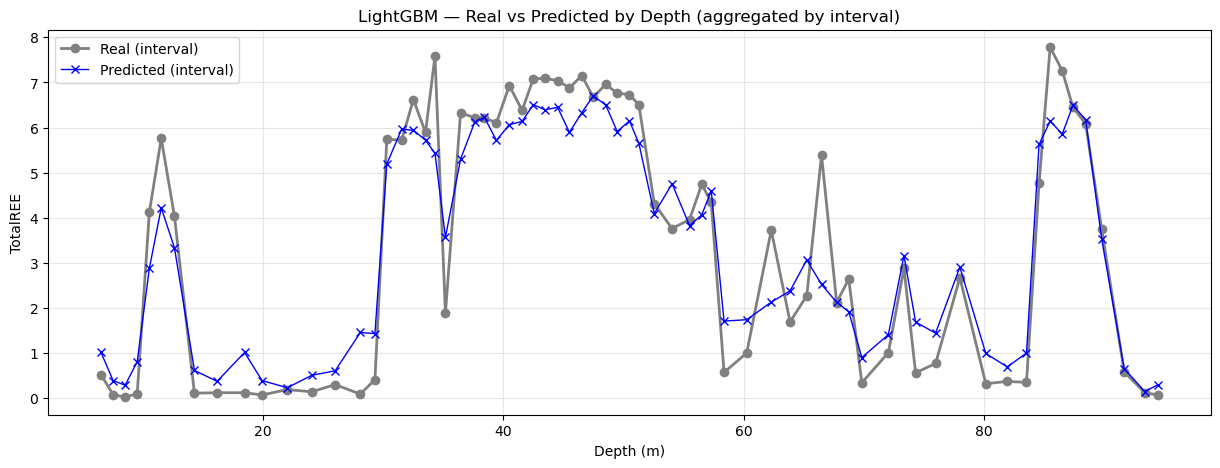

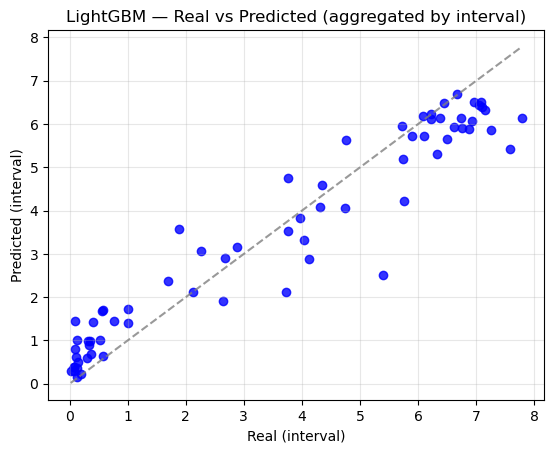

In [8]:
plt.figure(figsize=(15,5))
plt.plot(agg[DEPTH_COL], agg['y_true'], marker='o', label='Real (interval)', color='grey', linewidth=2)
plt.plot(agg[DEPTH_COL], agg['y_pred'], marker='x', label='Predicted (interval)', color='blue', linewidth=1)
# Optional: invert y-axis if you want depth increasing downwards
# plt.gca().invert_yaxis()
plt.xlabel("Depth (m)")
plt.ylabel(TARGET_COL)
plt.title("LightGBM — Real vs Predicted by Depth (aggregated by interval)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("lgbm_oof_profile.png", dpi=300)
plt.show()

# Scatter (bag-level)
plt.figure()
plt.scatter(agg['y_true'], agg['y_pred'], alpha=0.8, color='blue')
lims = [min(agg['y_true'].min(), agg['y_pred'].min()), max(agg['y_true'].max(), agg['y_pred'].max())]
plt.plot(lims, lims, '--', color='gray', alpha=0.8)
plt.xlabel("Real (interval)")
plt.ylabel("Predicted (interval)")
plt.title("LightGBM — Real vs Predicted (aggregated by interval)")
plt.grid(True, alpha=0.3)
plt.savefig("lgbm_oof_scatter.png", dpi=300)
plt.show()

## 6. SHAP — Feature interpretation

Use SHAP to interpret feature (wavelength) contributions. We compute SHAP values for a deterministic subsample of the data for speed, then plot summary (bar and beeswarm) and dependence plots for the top-K features.

C:\Users\thais\AppData\Local\Temp\ipykernel_1856\2164946715.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_bg, feature_names=feature_names, plot_type='bar', show=False)


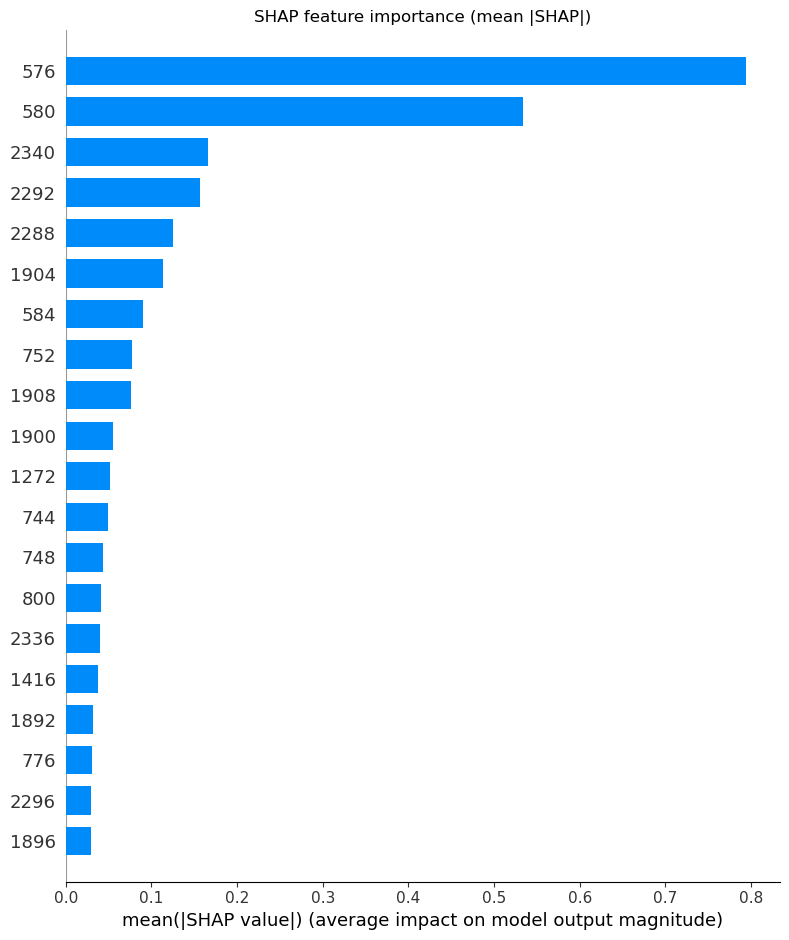

C:\Users\thais\AppData\Local\Temp\ipykernel_1856\2164946715.py:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_bg, feature_names=feature_names, show=False)


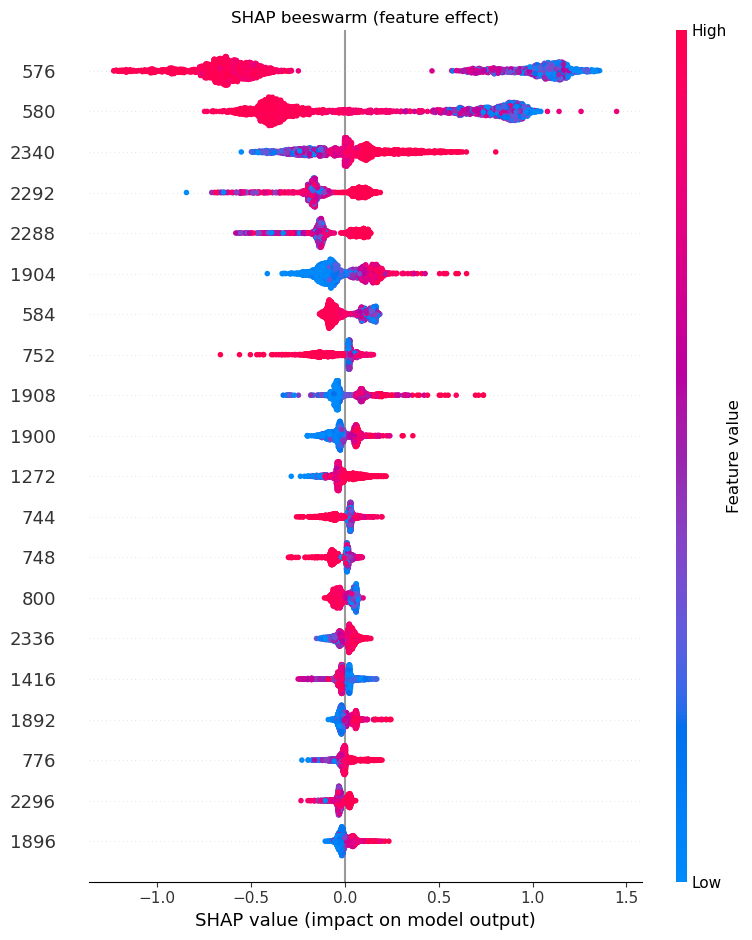

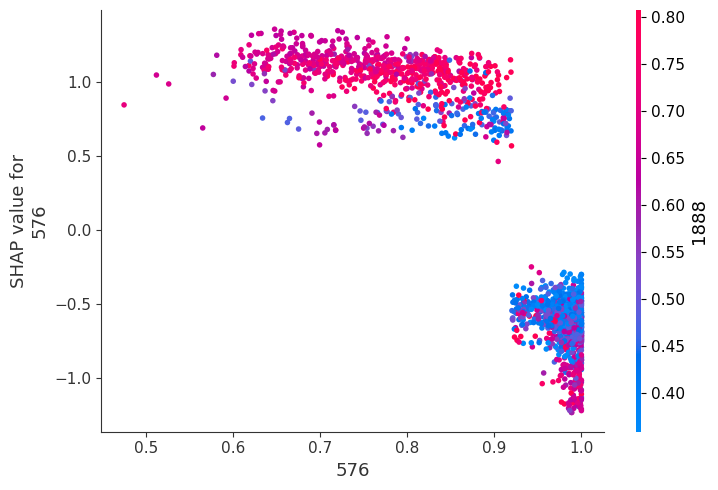

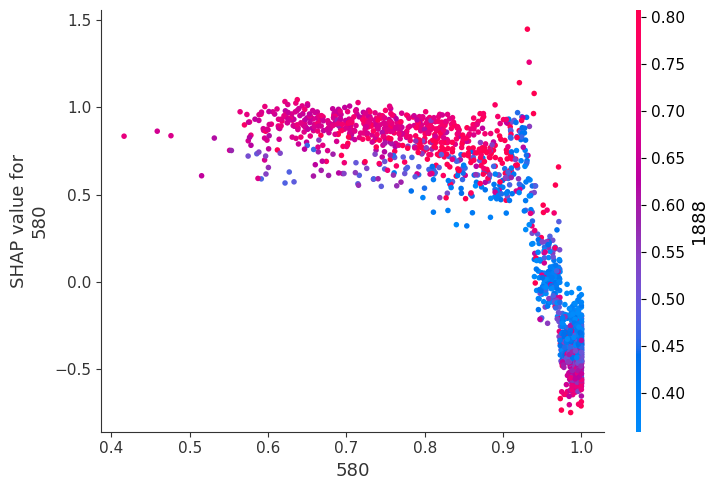

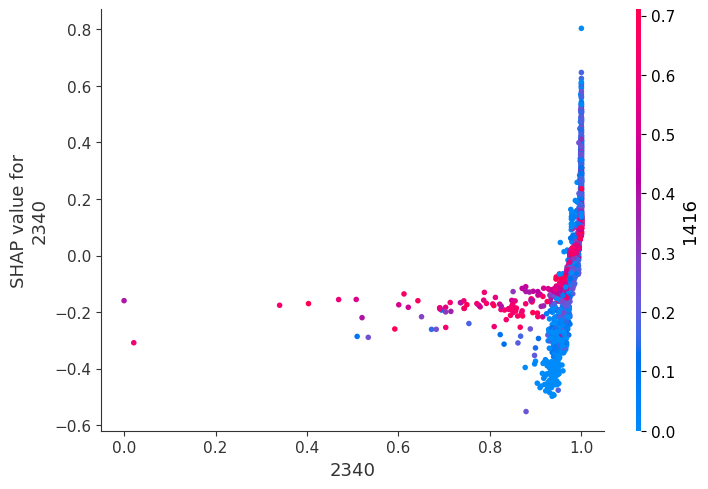

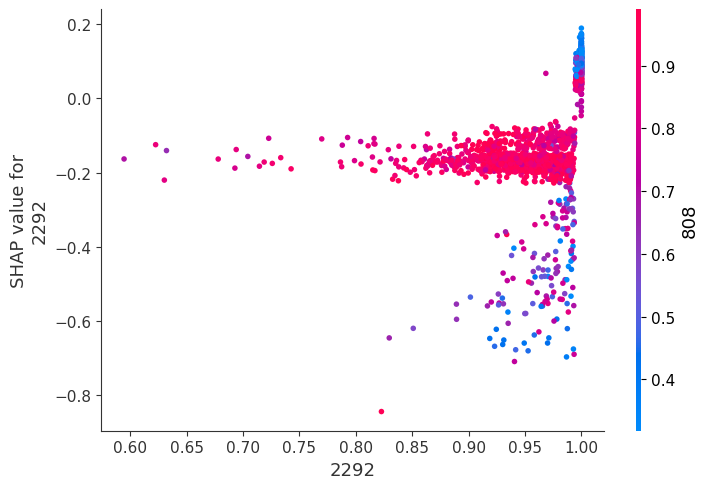

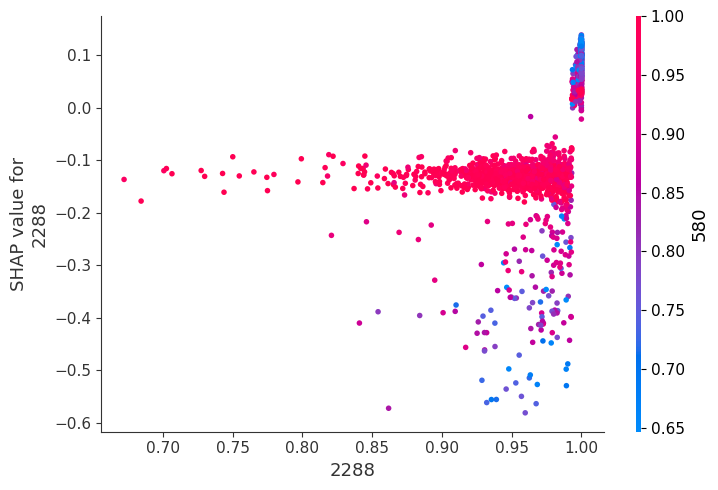

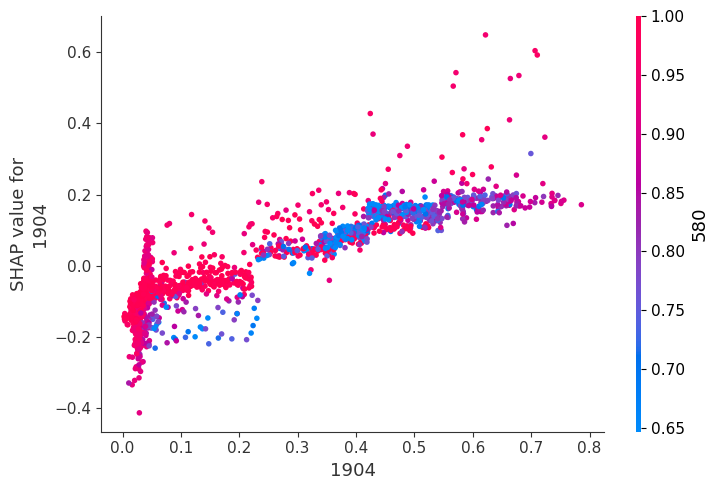

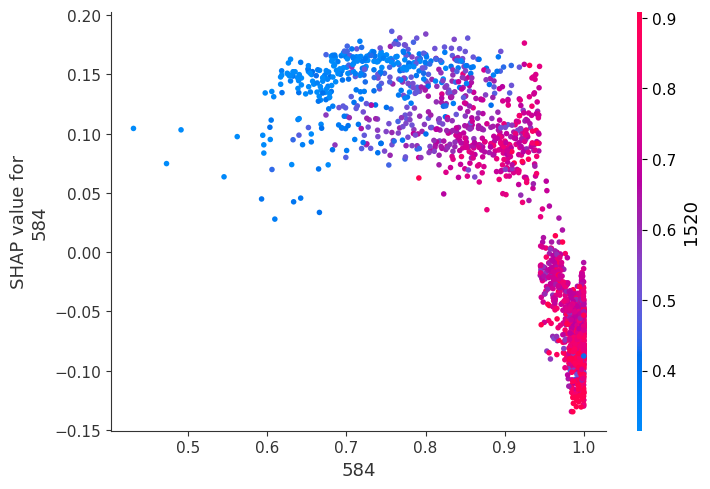

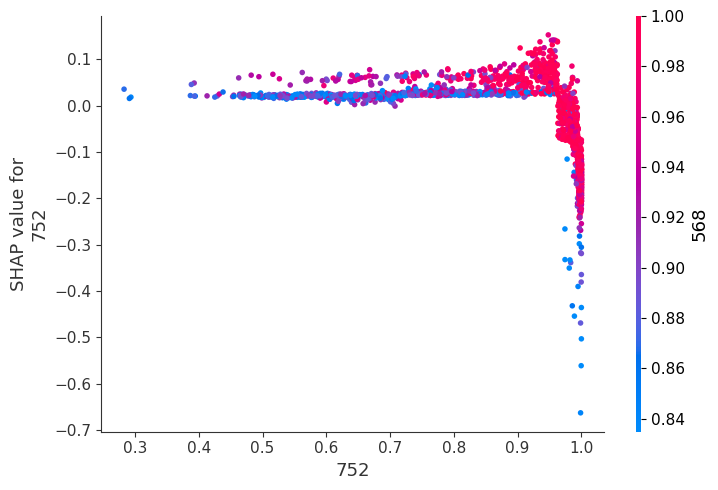

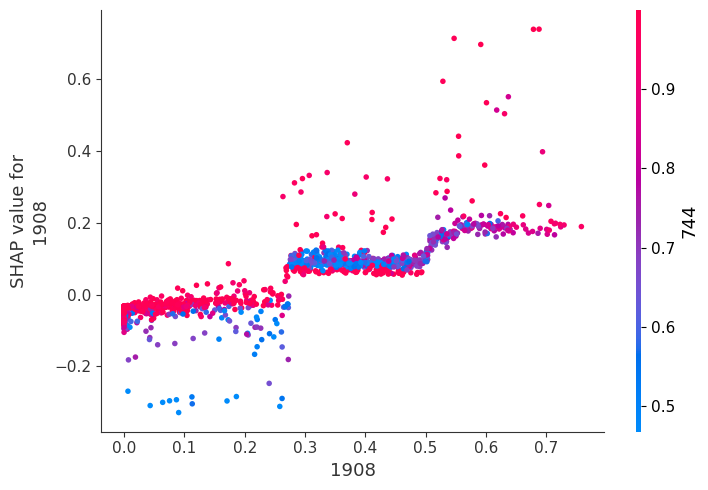

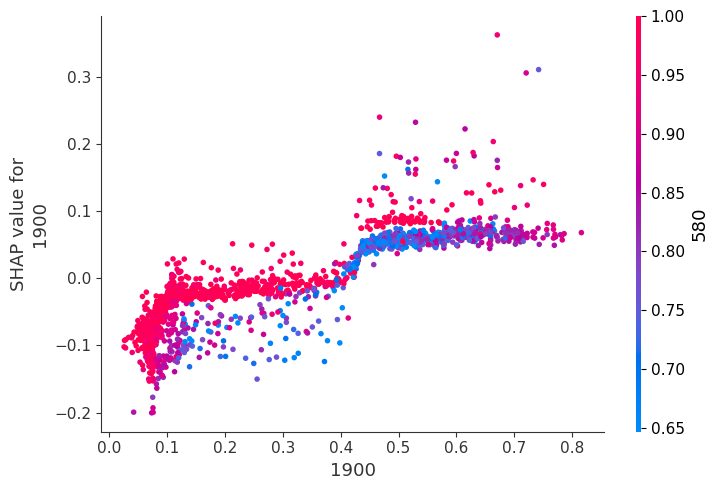

In [9]:
if len(models) == 0:
    print("[WARN] No trained models found — skipping SHAP explanation.")
else:
    # Choose model: last trained model is a reasonable default
    best_model = models[-1]

    # Build a TreeExplainer (LightGBM scikit-learn wrapper is supported)
    explainer = shap.TreeExplainer(best_model)

    # Subsample background for speed (deterministic)
    rng = np.random.RandomState(RANDOM_STATE)
    n_bg = min(2000, len(df))
    idx_bg = rng.choice(len(df), size=n_bg, replace=False)
    X_bg = X[idx_bg]

    # Compute SHAP values (regression -> single array)
    shap_values = explainer.shap_values(X_bg)

    # Feature names as strings
    feature_names = [str(c) for c in spectral_cols]

    # Summary bar (mean |SHAP|)
    try:
        shap.summary_plot(shap_values, X_bg, feature_names=feature_names, plot_type='bar', show=False)
        plt.title('SHAP feature importance (mean |SHAP|)')
        plt.tight_layout()
        plt.savefig('shap_summary_bar.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"[WARN] SHAP bar summary plot failed: {e}")

    # Beeswarm (detail of per-sample effects)
    try:
        shap.summary_plot(shap_values, X_bg, feature_names=feature_names, show=False)
        plt.title('SHAP beeswarm (feature effect)')
        plt.tight_layout()
        plt.savefig('shap_beeswarm.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"[WARN] SHAP beeswarm plot failed: {e}")

    # Dependence plots for top-K features by mean(|SHAP|)
    K = 10
    mean_abs = np.abs(shap_values).mean(axis=0)
    rank_idx = np.argsort(-mean_abs)[:K]

    for i in rank_idx:
        try:
            shap.dependence_plot(i, shap_values, X_bg, feature_names=feature_names, show=False)
            plt.tight_layout()
            plt.savefig(f'shap_dependence_{feature_names[i]}.png', dpi=300)
            plt.show()
        except Exception as e:
            print(f"[WARN] SHAP dependence plot for feature {feature_names[i]} failed: {e}")